In [1]:
import torch
import numpy as np

from torch import nn, optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tqdm import tqdm

%matplotlib inline

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

##Data generation

In [12]:
mu1 = torch.tensor([10., 3.], device=device, dtype=torch.float32)
mu2 = torch.tensor([3., 0.], device=device, dtype=torch.float32)
covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

p_data = 0.7 # prob of the first peak in data space
N = 10000 # amount of data
batch_size = 100
num_epoches = 500
z_dim = 2

tolerance = 100

In [13]:
c = torch.distributions.Bernoulli(p_data). sample((N, )).to(device).view(-1, 1)
a = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N, ))
b = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N, ))

In [14]:
X = c * a + (1 - c) * b
Y = torch.cat((X, c), 1)

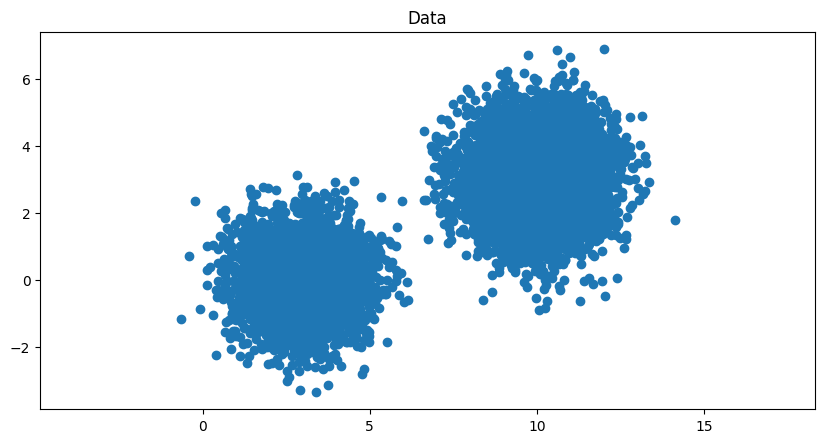

In [15]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Data')
plt.axis('equal')
plt.scatter(Y[:, 0].cpu(), Y[:, 1].cpu());

In [16]:
class VAE_MoG_prior(nn.Module):
  def __init__(self):
    super(VAE_MoG_prior, self).__init__()

    self.fc0 = nn.Linear(2, 5) # for encoder
    self.fc1 = nn.Linear(5, 10)
    self.fc2 = nn.Linear(10, z_dim) 
    self.fc3 = nn.Linear(10, z_dim)

    self.fc4 = nn.Linear(z_dim, 10) # for decoder
    self.fc5 = nn.Linear(10, 5)
    self.fc6 = nn.Linear(5, 2)
    
  def encode(self, x):
    h = torch.relu(self.fc0(x))
    g = torch.relu(self.fc1(h))
    return self.fc2(g), self.fc3(g) # mu and logvar -- parameters of q_{phi}
    
  def reparametrize(self, mu, logvar):
    std = torch.exp(logvar * 0.5)
    eps = torch.randn_like(std)
    return mu + eps * std
  
  def decode(self, z):
    h = torch.relu(self.fc4(z))
    g = torch.relu(self.fc5(h))
    return self.fc6(g) # mu_0 -- parameter of p_{theta}

  def forward(self, x):
    mu, logvar = self.encode(x)
    z = self.reparametrize(mu, logvar)
    return self.decode(z), mu, logvar

In [17]:
model = VAE_MoG_prior().to(device)

In [18]:
p_prior_logit = nn.Parameter(torch.rand(1, device=device, dtype=torch.float32), requires_grad=True)
m_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
m_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

logvar_1 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))
logvar_2 = nn.Parameter(torch.rand(2, device=device, dtype=torch.float32))

In [19]:
print("Initialization of params:")
print("p_prior_logit =", p_prior_logit)
print("m_1 =", m_1)
print("m_2 =", m_2)
print("logvar_1 =", logvar_1)
print("logvar_2 =", logvar_2)

Initialization of params:
p_prior_logit = Parameter containing:
tensor([0.4433], device='cuda:0', requires_grad=True)
m_1 = Parameter containing:
tensor([0.6041, 0.8489], device='cuda:0', requires_grad=True)
m_2 = Parameter containing:
tensor([0.6351, 0.4531], device='cuda:0', requires_grad=True)
logvar_1 = Parameter containing:
tensor([0.1073, 0.1225], device='cuda:0', requires_grad=True)
logvar_2 = Parameter containing:
tensor([0.4879, 0.6968], device='cuda:0', requires_grad=True)


In [20]:
params = list(model.parameters()) + [p_prior_logit, m_1, logvar_1, m_2, logvar_2]

In [21]:
optimizer = optim.Adam(params=params, lr=1e-2)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 50, 75, 100, 150, 200, 300, 400], gamma=0.5)

$L = KL - ELH = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - KL(q_{\phi}(z|x)||p(z))) = -(\mathbb{E}_{q_{\phi}(z|x)}\log{p_{\theta}(z|x)} - \mathbb{E}_{q_{\phi}(z|x)}(\log{q_{\phi}(z|x)} - \log{p(z)}))$

$\mathbb{E}_{q_{\phi}(z|x)}\log{q_{\phi}(z|x)} = \int q_{\phi}(z|x)\log{q_{\phi}(z|x)}dz = -\frac{J}{2}\log{2\pi} - \frac{1}{2}\sum_{j = 1}^{J}{(1+\log{\sigma_{j}^{2}})}$

In [22]:
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [23]:
def loss_function(x, mu_0, mu, logvar, p_prior_logit, m_1, m_2, logvar_1, logvar_2): # mu_0 -- mean of p_{theta}; mu, logvar -- parameters of q_{phi}, p, m_1, m_2, logvar_1, logvar_2 -- parameters of prior p(z)
  g_1 = torch.distributions.Normal(loc = m_1, scale=(logvar_1 * 0.5).exp())
  g_2 = torch.distributions.Normal(loc = m_2, scale = (logvar_2 * 0.5).exp())
  z_0 = mu + std_normal.sample(mu.shape) * (logvar * 0.5).exp() # reparametrization
  A = -0.5 * (1 + logvar)
  concat_tensor = torch.cat([(torch.log(torch.sigmoid(p_prior_logit)) + g_1.log_prob(z_0))[None], (torch.log(torch.sigmoid(1. - p_prior_logit)) + g_2.log_prob(z_0))[None]], dim=0)
  B = torch.logsumexp(concat_tensor, dim=0) #  1-MC approximation of E_{q_{phi}}[p(z)]
  KL = A - B
  p_theta = torch.distributions.MultivariateNormal(loc=mu_0, covariance_matrix=covar)
  ELH = p_theta.log_prob(x) # 1-MC approximation of expected log-likelihood
  return KL.mean() - ELH.mean()

In [24]:
dataloader = DataLoader(Y[:, 0:2], batch_size=batch_size, shuffle=True)

In [25]:
min_loss = np.inf
i = 0

for epoch in tqdm(range(num_epoches)):
    for batch in dataloader:
        mu_0, mu, logvar = model(batch)
        loss = loss_function(batch, mu_0, mu, logvar, p_prior_logit, m_1, m_2, logvar_1, logvar_2)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
    if loss < min_loss:
        min_loss = loss
        i = 0
    else:
        i += 1
    if i == tolerance:
        print("Early stopping after epoch", epoch)
        break
    if epoch % 50 == 0:
        print("loss =", loss.cpu().detach().numpy())

  0%|          | 1/500 [00:01<08:38,  1.04s/it]

loss = 5.9582243


 10%|█         | 51/500 [00:46<06:47,  1.10it/s]

loss = 5.218438


 20%|██        | 101/500 [01:32<05:54,  1.12it/s]

loss = 4.608917


 30%|███       | 151/500 [02:17<05:12,  1.12it/s]

loss = 4.2621307


 40%|████      | 201/500 [03:03<04:40,  1.06it/s]

loss = 4.0076222


 50%|█████     | 251/500 [03:50<04:06,  1.01it/s]

loss = 4.092553


 60%|██████    | 301/500 [04:35<02:55,  1.13it/s]

loss = 4.1601243


 70%|███████   | 351/500 [05:19<02:11,  1.13it/s]

loss = 4.1603646


 80%|████████  | 401/500 [06:04<01:26,  1.14it/s]

loss = 4.0123677


 90%|█████████ | 451/500 [06:48<00:42,  1.15it/s]

loss = 3.9630256


100%|██████████| 500/500 [07:32<00:00,  1.11it/s]


##Generation

In [26]:
p_prior = torch.sigmoid(p_prior_logit)

In [27]:
bern = torch.distributions.Bernoulli(p_prior).sample((1000, )).view(-1, 1)
g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp()).sample((1000, ))
g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp()).sample((1000, ))

pr_samples = bern * g_1 + (1 - bern) * g_2 # get 1000 samples from trained prior

In [28]:
mu_post = model.decode(pr_samples).detach() # p_{theta}(x|z)

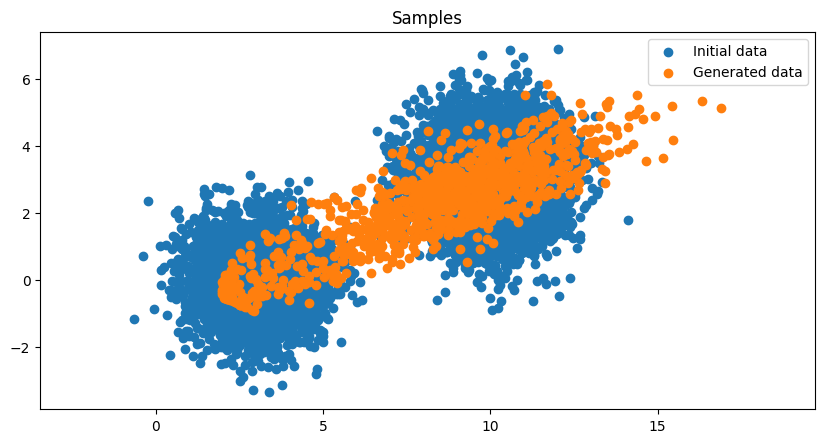

In [29]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(mu_post[:, 0].cpu(), mu_post[:, 1].cpu(), label='Generated data')
plt.axis('equal')
plt.legend();

##Prior visualization

In [30]:
print("Prior parameters:")
print("p_prior = ", p_prior.detach().cpu().numpy())
print("m_1 =", m_1.detach().cpu().numpy(), "logvar_1 =", logvar_1.detach().cpu().numpy())
print("m_2 =", m_2.detach().cpu().numpy(), "logvar_2 =", logvar_2.detach().cpu().numpy())

Prior parameters:
p_prior =  [0.6437268]
m_1 = [0.31007326 2.9613595 ] logvar_1 = [ 0.14666262 -0.35266203]
m_2 = [0.25812787 1.2947216 ] logvar_2 = [0.36556652 0.77231175]


No handles with labels found to put in legend.


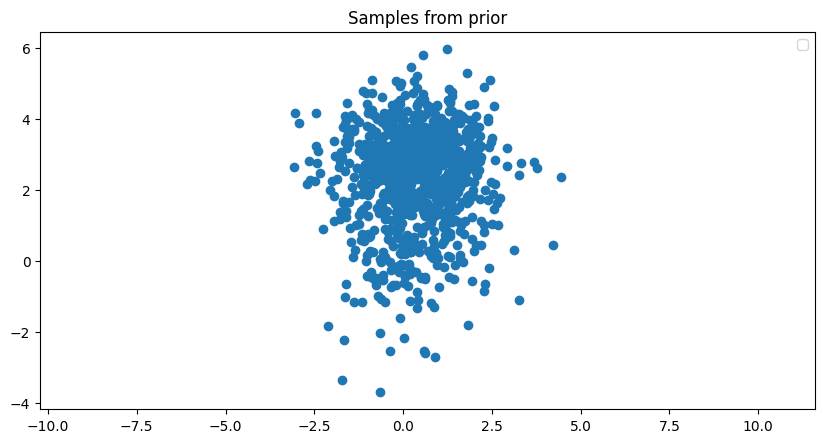

In [31]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples from prior')
plt.scatter(pr_samples[:, 0].cpu(), pr_samples[:, 1].cpu())
plt.axis('equal')
plt.legend();

##Reconstruction

In [32]:
X_rec = model(X) #reconstructed data

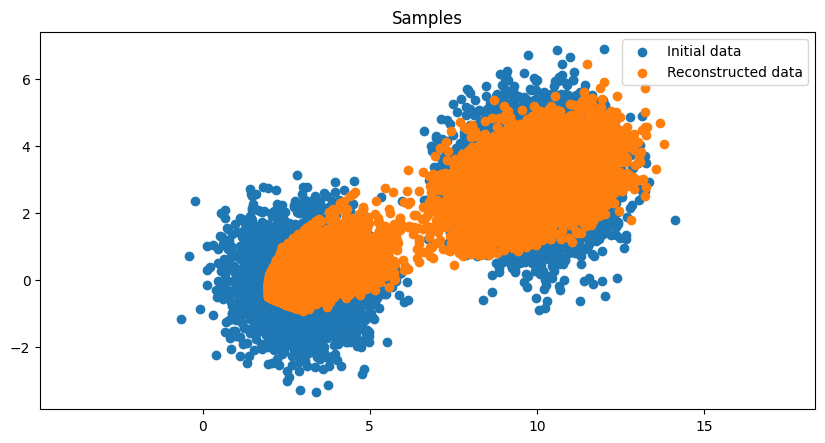

In [33]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(X[:, 0].cpu(), X[:, 1].cpu(), label='Initial data')
plt.scatter(X_rec[0][:, 0].detach().cpu(), X_rec[0][:, 1].detach().cpu(), label='Reconstructed data')
plt.axis('equal')
plt.legend();

##Latent space vizualization

In [34]:
mu1_q, logvar1_q = model.encode(Y[Y[:, 2] == 0, 0:2])
mu2_q, logvar2_q = model.encode(Y[Y[:, 2] == 1, 0:2])

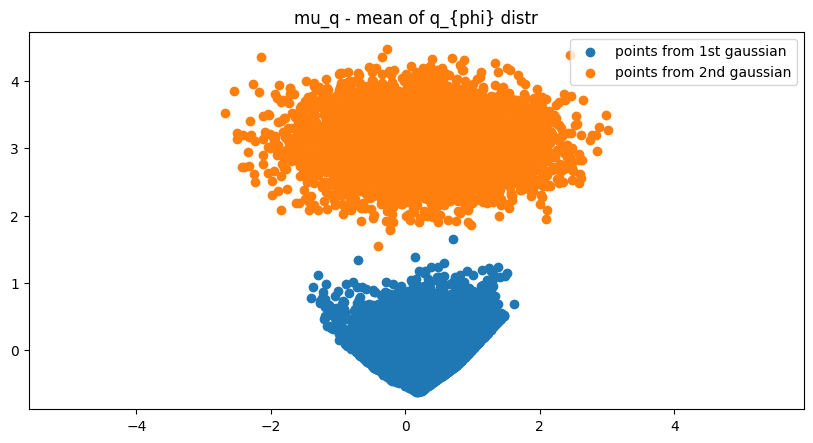

In [35]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('mu_q - mean of q_{phi} distr')
plt.scatter(mu1_q[:, 0].detach().cpu(), mu1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(mu2_q[:, 0].detach().cpu(), mu2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

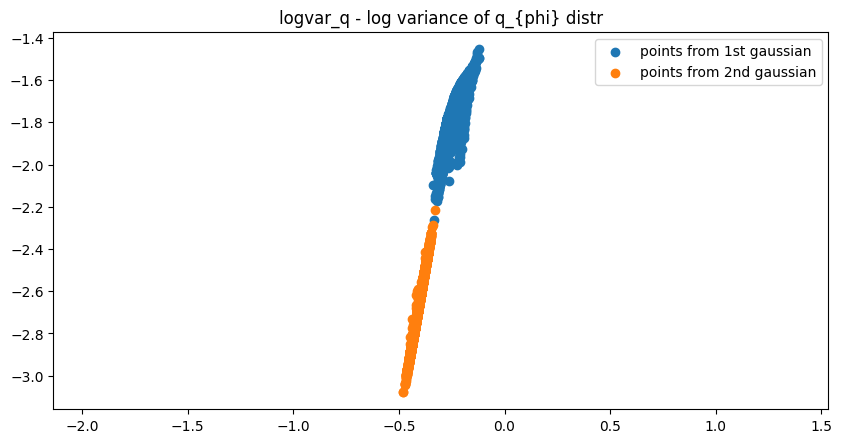

In [36]:
plt.figure(figsize=(10, 5), dpi=100)
plt.title('logvar_q - log variance of q_{phi} distr')
plt.scatter(logvar1_q[:, 0].detach().cpu(), logvar1_q[:, 1].detach().cpu(), label='points from 1st gaussian')
plt.scatter(logvar2_q[:, 0].detach().cpu(), logvar2_q[:, 1].detach().cpu(), label='points from 2nd gaussian')
plt.axis('equal')
plt.legend();

## Estimation of $\log{p_{\theta}(X)}$

In [37]:
N_IS = 10000
N_test = 5000

In [38]:
c_test = torch.distributions.Bernoulli(p_data). sample((N_test, )).to(device).view(-1, 1)
a_test = torch.distributions.MultivariateNormal(loc=mu1, covariance_matrix=covar).sample((N_test, ))
b_test = torch.distributions.MultivariateNormal(loc=mu2, covariance_matrix=covar).sample((N_test, ))

X_test = c_test * a_test + (1 - c_test) * b_test

In [39]:
def prior_log_prob(z, p_prior, m_1, logvar_1, m_2, logvar_2): # returns log p_{lambda}(z) for MoG prior
    g_1 = torch.distributions.Normal(loc=m_1, scale=(logvar_1 * 0.5).exp())
    g_2 = torch.distributions.Normal(loc=m_2, scale=(logvar_2 * 0.5).exp())
    concat_tensor = torch.cat([(torch.log(p_prior) + g_1.log_prob(z))[None], (torch.log(1. - p_prior) + g_2.log_prob(z))[None]], dim=0)
    return torch.logsumexp(concat_tensor, dim=0)

In [40]:
torch.manual_seed(0)
np.random.seed(0)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                        scale=torch.tensor(1., device=device, dtype=torch.float32))

In [41]:
test_batch_size = 10
test_dataloader = DataLoader(X_test, batch_size=test_batch_size, shuffle=False, )

In [42]:
batch_mean = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        batch = batch.repeat(N_IS, 1)
        mu_q, logvar_q = model.encode(batch)
        
        eps = std_normal.sample(mu_q.shape)
        z = mu_q + eps * torch.exp(logvar_q * 0.5)
        m_0 = model.decode(z) # means of p_theta
        
        log_p_theta = torch.distributions.MultivariateNormal(loc=m_0, covariance_matrix=covar).log_prob(m_0)
        log_q = std_normal.log_prob(eps).sum(1)
        log_prior = prior_log_prob(z, p_prior, m_1, logvar_1, m_2, logvar_2).sum(1)
 
        ll_raw = (log_p_theta + log_prior - log_q).view(*[N_IS, -1])
        
        ll_lse = torch.logsumexp(ll_raw, dim=0)
        ll = -np.log(N_IS) + torch.mean(ll_lse)
        batch_mean.append(torch.mean(ll).cpu().detach().numpy())

100%|██████████| 500/500 [00:02<00:00, 217.24it/s]


In [43]:
print("mean =", np.mean(batch_mean)) # mean of log p_{theta}(x)
print("std =", np.std(batch_mean))

mean = -1.1245317
std = 0.20097658
